In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
%pip install xgboost

In [ ]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.3 MB/s eta 0:00:00


In [19]:
import optuna
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load the data
# df = pd.read_csv('./drive/MyDrive/VagusNerveResearchProject/vns_dataset_threshold_sim.csv')

# # Transform the data
# data_ab = df.copy()
# data_ab = data_ab[data_ab['C_activation_level'] == 0.0]
# data_ab = data_ab[['nerve_a', 'nerve_b', 'pulse_width', 'frequency', 'amplitude', 'AB_activation_level']]
# data_ab.columns = ['nerve_a', 'nerve_b', 'pulse_width', 'frequency', 'amplitude', 'activation_level']
# data_ab['fibre_type'] = 'AB'

# # Transform the data for C fibers
# data_c = df.copy()
# data_c = data_c[data_c['AB_activation_level'] == 1.0]
# data_c = data_c[['nerve_a', 'nerve_b', 'pulse_width', 'frequency', 'amplitude', 'C_activation_level']]
# data_c.columns = ['nerve_a', 'nerve_b', 'pulse_width', 'frequency', 'amplitude', 'activation_level']
# data_c['fibre_type'] = 'C'

# df_transformed = pd.concat([data_ab, data_c], ignore_index=True)

# df_transformed['charge'] = df_transformed['pulse_width'] * df_transformed['amplitude']

# # Encode the categorical feature
# label_encoder = LabelEncoder()
# df_transformed['fibre_type'] = label_encoder.fit_transform(df_transformed['fibre_type'])

data = pd.read_csv('./drive/MyDrive/VagusNerveResearchProject/vns_dataset_threshold_type.csv')

data.loc[data['fibre_type'] == 'AB', 'fibre_type'] = 0.0
data.loc[data['fibre_type'] == 'C', 'fibre_type'] = 1.0

# Encode the categorical feature
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

X_cat = one_hot_encode(data[['fibre_type']].astype('int'), num_classes=2)
X_cat = X_cat.reshape(-1, 2)

# Split the data
X = data[['nerve_a', 'nerve_b', 'activation_level', 'frequency', 'pulse_width']]
X.loc[:, 'fibre_type_AB'] = X_cat[:, 0]
X.loc[:, 'fibre_type_C'] = X_cat[:, 1]
y = data[['amplitude']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the continuous features
scaler = StandardScaler()
X_train_cont = scaler.fit_transform(X_train[['nerve_a', 'nerve_b', 'activation_level', 'frequency', 'pulse_width']])
X_test_cont = scaler.transform(X_test[['nerve_a', 'nerve_b', 'activation_level', 'frequency', 'pulse_width']])

# Extract the encoded labels
X_train_cat = X_train[['fibre_type_AB', 'fibre_type_C']].values
X_test_cat = X_test[['fibre_type_AB', 'fibre_type_C']].values

# Concatenate continuous and categorical features
X_train = np.hstack((X_train_cont, X_train_cat))
X_test = np.hstack((X_test_cont, X_test_cat))

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)

<ipython-input-19-81666153b08d>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'fibre_type_AB'] = X_cat[:, 0]
<ipython-input-19-81666153b08d>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'fibre_type_C'] = X_cat[:, 1]


In [20]:
X_train[:5]

array([[ 0.076614  ,  0.16115042, -1.37691544, -0.74408584,  0.39545059,
         0.        ,  1.        ],
       [ 0.90454025,  1.96861148,  0.90896563, -0.56777069, -0.68303117,
         0.        ,  1.        ],
       [-0.00976723,  0.71154822, -0.43918706, -0.27391211,  1.7435528 ,
         0.        ,  1.        ],
       [ 0.90454025,  1.96861148, -1.08366981, -0.80285756, -0.68303117,
         0.        ,  1.        ],
       [-0.99841328, -1.32168014,  0.54607043, -0.74408584, -0.27860051,
         1.        ,  0.        ]])

In [21]:
def create_model(trial: optuna.Trial):
    # Define hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)

    # Create the model
    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        objective='reg:squarederror',
        random_state=42,
        use_label_encoder=False,
        verbosity=0
    )

    return model

def objective(trial):
    # Create the model
    model = create_model(trial)

    # Fit the model
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    # Predict on the test set
    preds = model.predict(X_test)
    # Calculate the mean squared error manually
    mse = np.power(y_test - preds, 2).mean()

    return mse


In [22]:
# Create study and optimize
study = optuna.create_study(direction='minimize') #directions=['minimize', 'minimize'])
study.optimize(objective, n_trials=100)

[I 2024-08-05 11:13:43,348] A new study created in memory with name: no-name-8967eb46-0b95-46d9-8546-75091fe72b66
[I 2024-08-05 11:14:24,355] Trial 0 finished with value: 1.0044307464647562 and parameters: {'n_estimators': 784, 'max_depth': 8, 'learning_rate': 2.347787674954931e-05, 'subsample': 0.8288091435423977, 'colsample_bytree': 0.773498279966474}. Best is trial 0 with value: 1.0044307464647562.
[I 2024-08-05 11:14:29,547] Trial 1 finished with value: 1.004362197145569 and parameters: {'n_estimators': 922, 'max_depth': 9, 'learning_rate': 1.3353121546776805e-05, 'subsample': 0.606113652839716, 'colsample_bytree': 0.9909762422232281}. Best is trial 1 with value: 1.004362197145569.
[I 2024-08-05 11:14:36,344] Trial 2 finished with value: 1.0197835595562932 and parameters: {'n_estimators': 844, 'max_depth': 3, 'learning_rate': 0.00021686942733090565, 'subsample': 0.8101672908101836, 'colsample_bytree': 0.835615866108175}. Best is trial 1 with value: 1.004362197145569.
[I 2024-08-05 

In [23]:
best_trial = study.best_trial
best_hyperparams = best_trial.params
# best_hyperparams = {'n_estimators': 296, 'max_depth': 9, 'learning_rate': 0.060787903971639065, 'subsample': 0.9991350385096723, 'colsample_bytree': 0.7509004665350101}
# Create and compile the best model
best_model = create_model(optuna.trial.FixedTrial(best_hyperparams))

# Train the best model
best_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
# Predict on the test set
preds = best_model.predict(X_test)
# Calculate the mean squared error manually
mse = np.power(y_test - preds, 2).mean()
print(f"Final score (test MSE): {mse}")


Final score (test MSE): 1.004240340894667


In [24]:
# Inverse transform the predictions
y_pred = y_scaler.inverse_transform(preds.reshape(-1, 1))
y_test = y_scaler.inverse_transform(y_test)


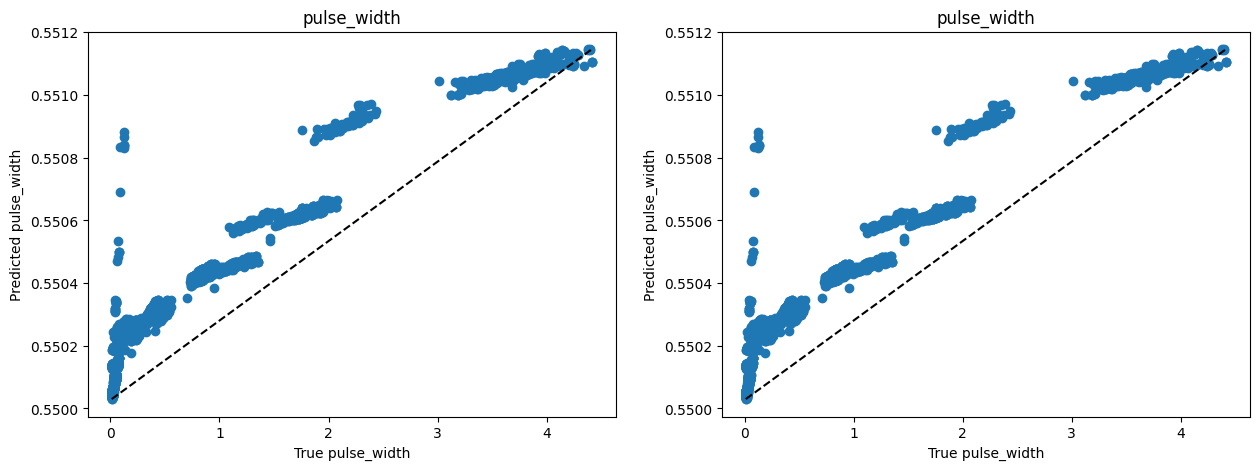

In [25]:
import matplotlib.pyplot as plt

# Plot the predictions for each output
params = ['pulse_width', 'amplitude']
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
i = 0
for j, ax in enumerate(axes):
    ax.scatter(y_test[:, i], y_pred[:, i])
    ax.plot([min(y_test[:, i]), max(y_test[:, i])], [min(y_pred[:, i]), max(y_pred[:, i])], linestyle='--', color='black')
    ax.set_xlabel(f'True {params[i]}')
    ax.set_ylabel(f'Predicted {params[i]}')
    ax.set_title(f'{params[i]}')


In [ ]:
best_model.save('parameter-model-20240724.keras')

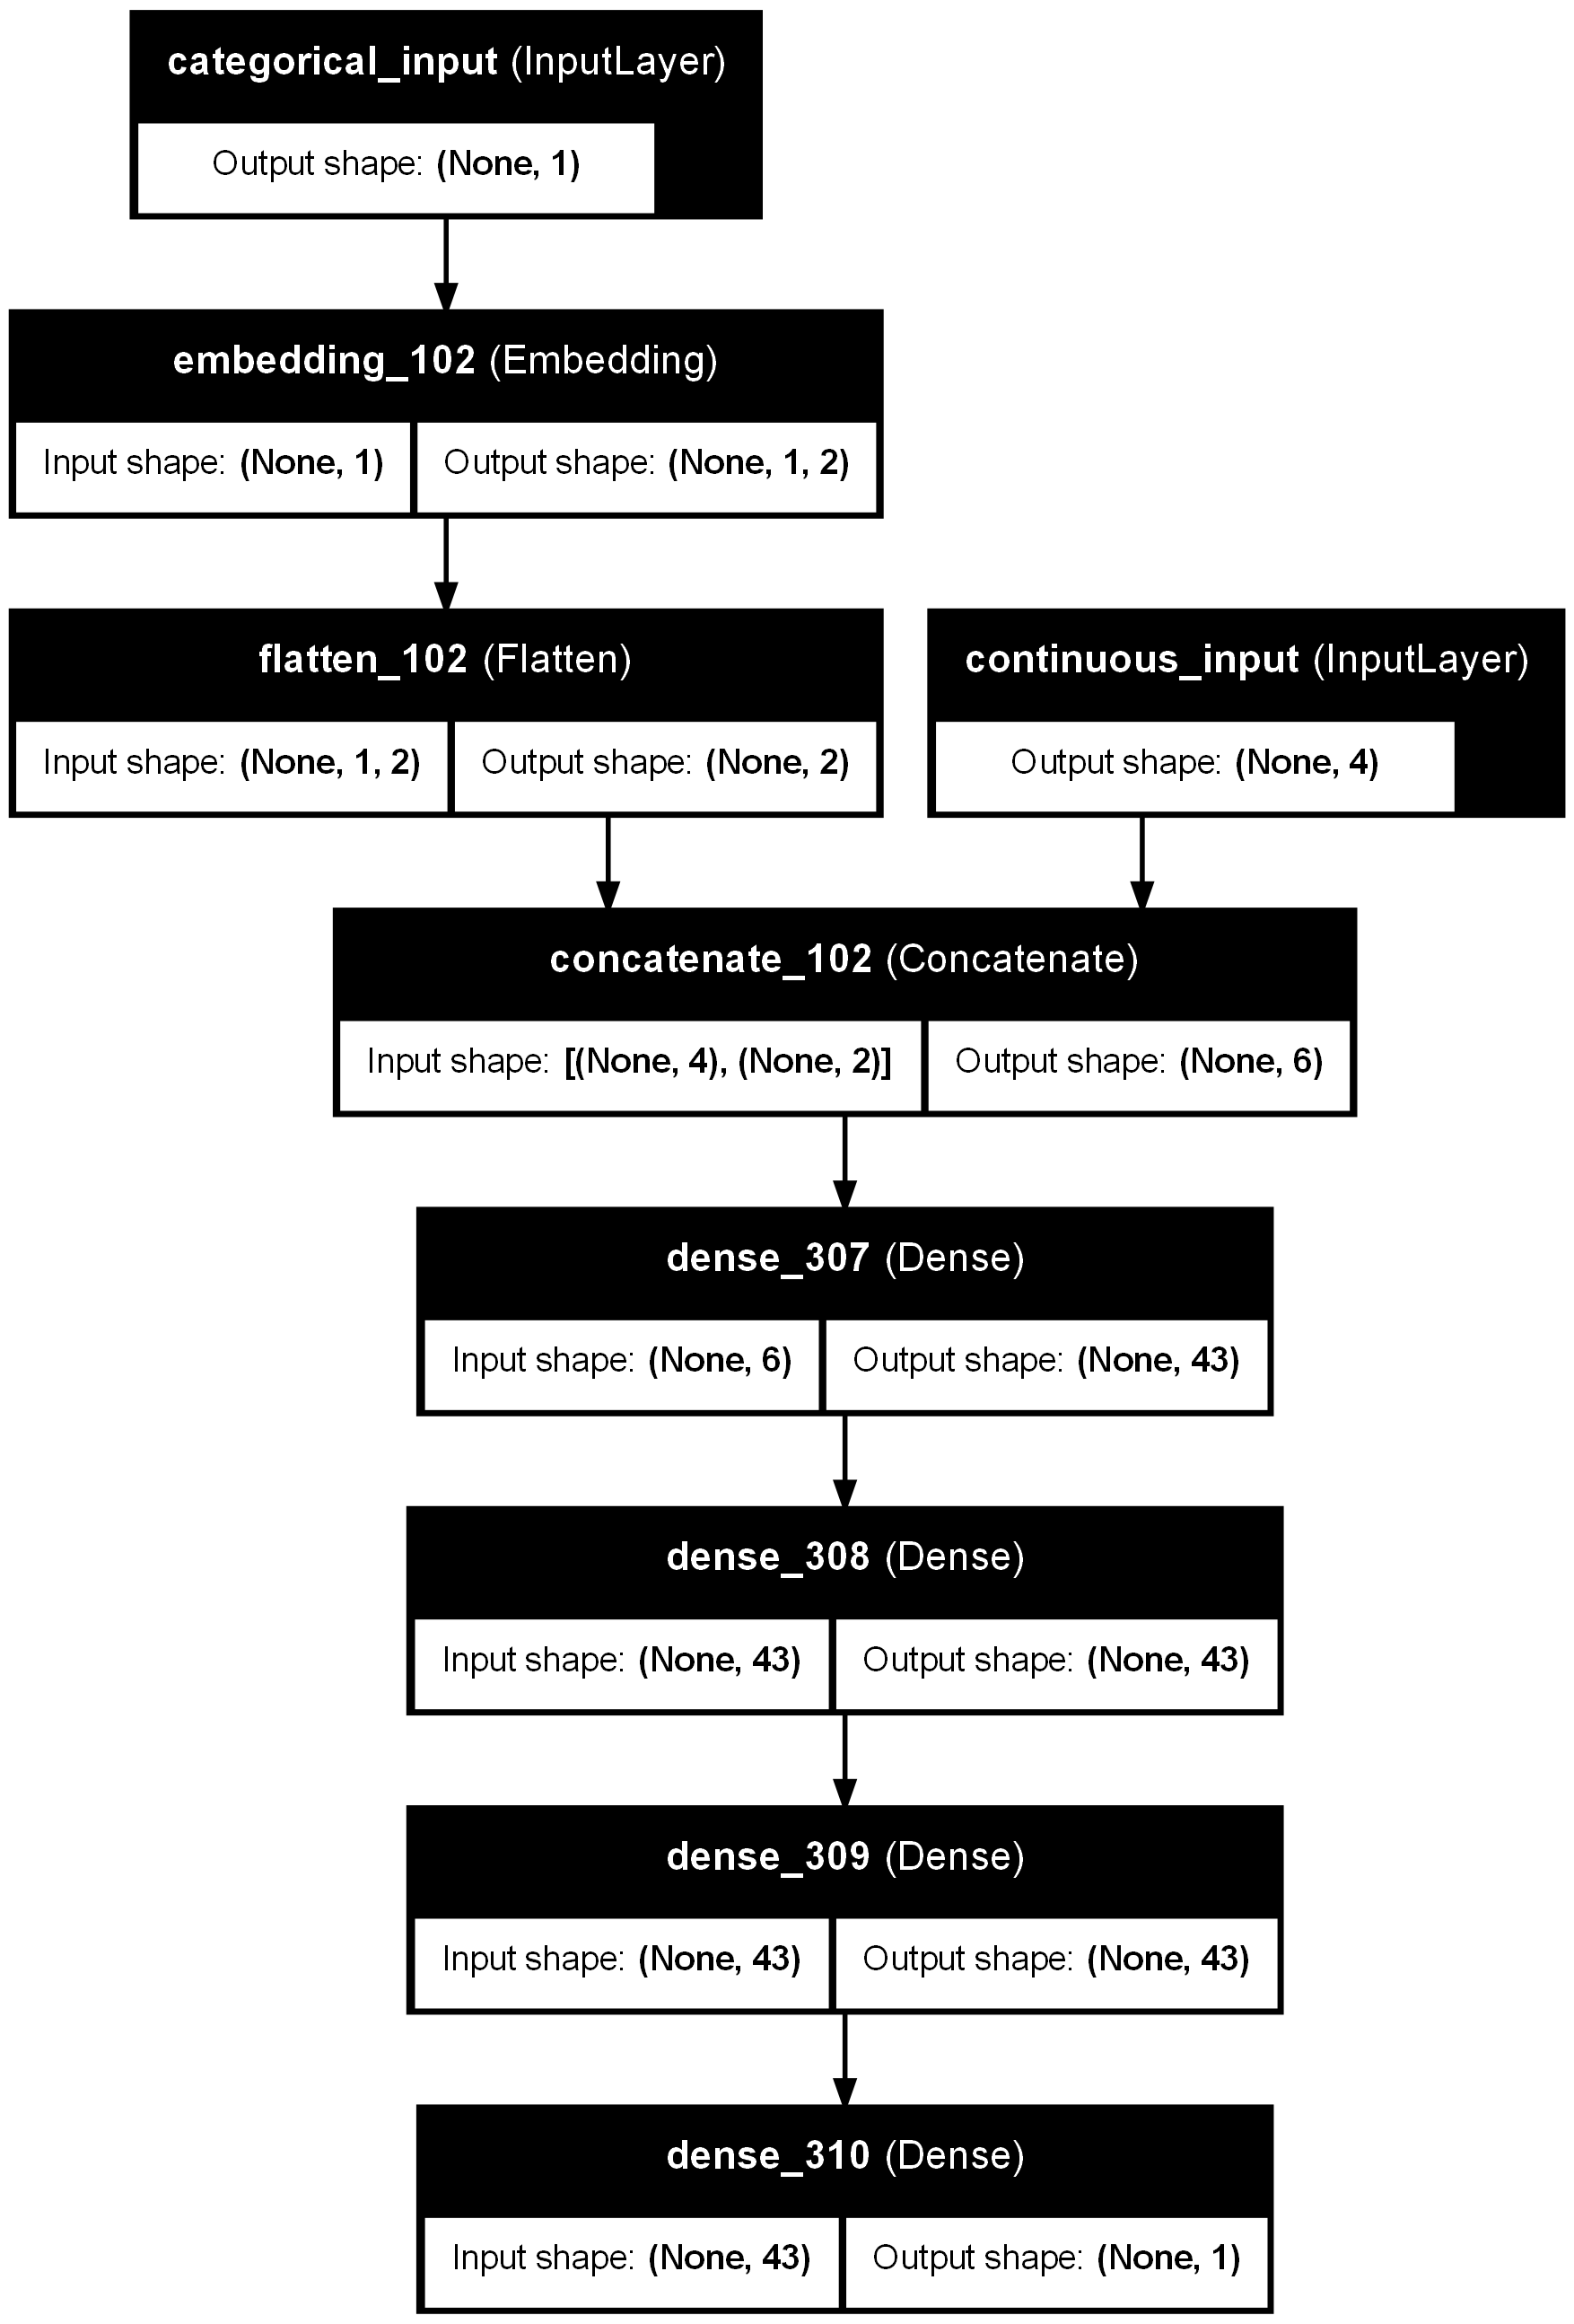

In [ ]:
from keras import utils

utils.plot_model(best_model, show_shapes=True, show_layer_names=True)

In [ ]:
# save study
import pickle

with open('./models/parameters-study.pkl', 'wb') as f:
    pickle.dump(study, f)

In [ ]:
from optuna.visualization import plot_contour

params = [
    'n_layers',
    'layer_size',
    'learning_rate'
]

plot_contour(study, target=lambda t: t.values[0], params=['n_layers', 'layer_size'])